In [40]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from itertools import product

# Modelo de predicción de pagos

## Base

Tenemos una base con la información siguiente: 
 - 1200 pagos únicos
 - 200  empresas únicas 
 - 77   instituciones que reciben los pagos
 - 8 meses, 3 del 2021 y 5 del 2022

In [2]:
base_pagos = pd.read_csv('/users/efrainrodriguez/downloads/data_test(2).csv')

base_pagos.head()

,PayerId,ReceiverId,invoiceId,paidAt,amount,amountfinancedByXepelin,status
0,53,10,18660729,2022-04-23 00:00:00,1490.46,0.00,PAID
1,93,11,18660730,2021-11-20 00:00:00,6418.28,624.48,PAID
2,122,12,18660731,2021-10-19 00:00:00,27979.20,10520.15,PAID
3,85,13,18660732,2021-11-13 00:00:00,183070.77,79421.63,PAID
4,87,14,18660733,2022-03-23 00:00:00,20532.00,20532.00,PAID


In [3]:
base_pagos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PayerId                  1200 non-null   int64  
 1   ReceiverId               1200 non-null   int64  
 2   invoiceId                1200 non-null   int64  
 3   paidAt                   892 non-null    object 
 4   amount                   1200 non-null   float64
 5   amountfinancedByXepelin  1200 non-null   float64
 6   status                   1200 non-null   object 
dtypes: float64(2), int64(3), object(2)
memory usage: 65.8+ KB


## Limpieza y analisis de la base

Tenemos 308 registros sin fecha de pago, pues son los pagos que no se pudieron efectuar. Además, tenemos una 269 pagos aún en procesamiento y 39 pagos fallidos. 

Para el análisis, descartaremos los 269 pagos en procesamiento. 

In [4]:
base_pagos.isna().sum()

PayerId                      0
ReceiverId                   0
invoiceId                    0
paidAt                     308
amount                       0
amountfinancedByXepelin      0
status                       0
dtype: int64

In [22]:
base_pagos['status'].value_counts()

PAID          892
PROCESSING    269
FAILED         39
Name: status, dtype: int64

In [21]:
base_pagos.groupby(['status'])['amountfinancedByXepelin'].sum()

status
FAILED         2435517.73
PAID          16544913.41
PROCESSING     2011203.00
Name: amountfinancedByXepelin, dtype: float64

In [25]:
base_pagos.groupby(['status'])['amount'].sum()

status
FAILED         2610972.74
PAID          27431012.91
PROCESSING     3380613.38
Name: amount, dtype: float64

In [9]:
pagos = pd.DataFrame(base_pagos.groupby('PayerId')['ReceiverId'].value_counts())
pagos.columns = ['Pago']

pagos.reset_index().sort_values(by=['Pago'],ascending=False)

,PayerId,ReceiverId,Pago
226,44,14,5
32,8,14,3
958,177,14,3
340,67,14,3
152,30,14,3
...,...,...,...
384,75,58,1
385,75,64,1
386,75,126,1
387,76,14,1


In [10]:
base_pagos['paidAt_fecha'] = pd.to_datetime(base_pagos['paidAt'])

In [11]:
base_pagos['paidAt_fecha'].dt.year.value_counts()

2022.0    857
2021.0     35
Name: paidAt_fecha, dtype: int64

In [12]:
base_pagos['paidAt_fecha'].dt.month.value_counts()

4.0     269
3.0     225
2.0     183
1.0     107
5.0      73
12.0     17
11.0     13
10.0      5
Name: paidAt_fecha, dtype: int64

In [14]:
base_pagos['Mes'] = base_pagos['paidAt_fecha'].dt.month

In [17]:
pd.DataFrame(base_pagos.groupby(['PayerId'])['Mes'].value_counts())

Mes
PayerId Mes      
1       2.0     2
        3.0     2
        4.0     1
        12.0    1
2       2.0     1
...           ...
199     2.0     2
        4.0     2
        5.0     1
200     1.0     1
        2.0     1

[584 rows x 1 columns]

In [96]:
base_pagos.groupby(['PayerId','Mes'])['status'].value_counts()

PayerId  Mes   status
1        2.0   PAID      2
         3.0   PAID      2
         4.0   PAID      1
         12.0  PAID      1
2        2.0   PAID      1
                        ..
199      2.0   PAID      2
         4.0   PAID      2
         5.0   PAID      1
200      1.0   PAID      1
         2.0   PAID      1
Name: status, Length: 584, dtype: int64

Para hacer un modelo por mes, hacemos la agregación por mes por payer id.

In [274]:
pagos_por_mes = pd.DataFrame(base_pagos[base_pagos['status']=='PAID'].groupby(['PayerId','Mes'])['amount'].sum()).reset_index()
pagos_por_mes['Mes'] = pagos_por_mes['Mes'].astype('int')
pagos_por_mes.head(10)

,PayerId,Mes,amount
0,1,2,2980.52
1,1,3,2365.52
2,1,4,1885.46
3,1,12,10523.52
4,2,2,10932.49
5,2,3,1255.06
6,2,5,1490.46
7,4,3,1792.46
8,4,4,2209.66
9,5,2,27287.94


In [275]:
base_pagos_por_mes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   PayerId  1600 non-null   int64
 1   Mes      1600 non-null   int64
dtypes: int64(2)
memory usage: 25.1 KB


In [276]:
# Creamos una base con las combinaciones 

base_pagos_por_mes = pd.DataFrame(list(product(base_pagos['PayerId'].unique(),[10,11,12,1,2,3,4,5])))
base_pagos_por_mes.columns = ['PayerId','Mes']

base_pagos_por_mes.head(10)

,PayerId,Mes
0,53,10
1,53,11
2,53,12
3,53,1
4,53,2
5,53,3
6,53,4
7,53,5
8,93,10
9,93,11


In [277]:
# Base con todos los meses + pagos

base_pagos_por_mes_modelo = base_pagos_por_mes.merge(pagos_por_mes,on=['PayerId','Mes'],how='left').fillna(0)
base_pagos_por_mes_modelo.head()

,PayerId,Mes,amount
0,53,10,0.0
1,53,11,0.0
2,53,12,0.0
3,53,1,0.0
4,53,2,0.0


In [278]:
base_pagos_por_mes_modelo['Pago_mes_pasado'] = base_pagos_por_mes_modelo.groupby('PayerId')['amount'].shift(1).fillna(0)
base_pagos_por_mes_modelo['Pago_hace_dos_meses'] = base_pagos_por_mes_modelo.groupby('PayerId')['amount'].shift(2).fillna(0)

In [279]:
base_pagos_por_mes_modelo.head(10)

,PayerId,Mes,amount,Pago_mes_pasado,Pago_hace_dos_meses
0,53,10,0.00,0.00,0.00
1,53,11,0.00,0.00,0.00
2,53,12,0.00,0.00,0.00
3,53,1,0.00,0.00,0.00
4,53,2,0.00,0.00,0.00
5,53,3,2234.12,0.00,0.00
6,53,4,2980.92,2234.12,0.00
7,53,5,0.00,2980.92,2234.12
8,93,10,0.00,0.00,0.00
9,93,11,6418.28,0.00,0.00


In [280]:
base_pagos_por_mes_train = base_pagos_por_mes_modelo[(base_pagos_por_mes_modelo['Mes']<=3)|(base_pagos_por_mes_modelo['Mes']>=10)]
base_pagos_por_mes_test = base_pagos_por_mes_modelo[(base_pagos_por_mes_modelo['Mes']>3)&(base_pagos_por_mes_modelo['Mes']<=10)]

base_pagos_por_mes_train.head(10)
                                                     

,PayerId,Mes,amount,Pago_mes_pasado,Pago_hace_dos_meses
0,53,10,0.00,0.00,0.00
1,53,11,0.00,0.00,0.00
2,53,12,0.00,0.00,0.00
3,53,1,0.00,0.00,0.00
4,53,2,0.00,0.00,0.00
5,53,3,2234.12,0.00,0.00
8,93,10,0.00,0.00,0.00
9,93,11,6418.28,0.00,0.00
10,93,12,0.00,6418.28,0.00
11,93,1,0.00,0.00,6418.28


In [281]:
base_pagos_por_mes_train_2 = pd.get_dummies(base_pagos_por_mes_train,columns=['PayerId'],drop_first=True)
base_pagos_por_mes_train_2['constant'] = 1
base_pagos_por_mes_train_2.head()

,Mes,amount,Pago_mes_pasado,Pago_hace_dos_meses,PayerId_2,PayerId_3,PayerId_4,PayerId_5,PayerId_6,PayerId_7,...,PayerId_192,PayerId_193,PayerId_194,PayerId_195,PayerId_196,PayerId_197,PayerId_198,PayerId_199,PayerId_200,constant
0,10,0.0,0.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,11,0.0,0.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,12,0.0,0.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0.0,0.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2,0.0,0.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Modelo regresor

In [282]:
features = [x for x in base_pagos_por_mes_train_2.columns if x not in ['amount']]

features[0:10]

['Mes',
 'Pago_mes_pasado',
 'Pago_hace_dos_meses',
 'PayerId_2',
 'PayerId_3',
 'PayerId_4',
 'PayerId_5',
 'PayerId_6',
 'PayerId_7',
 'PayerId_8']

In [283]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=500)

model = rf.fit(base_pagos_por_mes_train_2[features],base_pagos_por_mes_train_2[['amount']])

/var/folders/6y/95kskh9d0kq91_lk7lm13py40000gn/T/ipykernel_37538/1523926894.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = rf.fit(base_pagos_por_mes_train_2[features],base_pagos_por_mes_train_2[['amount']])


In [284]:
base_pagos_por_mes_test_2 = pd.get_dummies(base_pagos_por_mes_test,columns=['PayerId'],drop_first=True)
base_pagos_por_mes_test_2['constant'] = 1
base_pagos_por_mes_test_2['prediction'] = rf.predict(base_pagos_por_mes_test_2[features])
base_pagos_por_mes_test_2['error'] = np.abs(base_pagos_por_mes_test_2['prediction'] - base_pagos_por_mes_test_2['amount'])
base_pagos_por_mes_test_2.head()

,Mes,amount,Pago_mes_pasado,Pago_hace_dos_meses,PayerId_2,PayerId_3,PayerId_4,PayerId_5,PayerId_6,PayerId_7,...,PayerId_194,PayerId_195,PayerId_196,PayerId_197,PayerId_198,PayerId_199,PayerId_200,constant,prediction,error
0,10,0.00,0.00,0.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.00000,0.00000
6,4,2980.92,2234.12,0.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1492.87028,1488.04972
7,5,0.00,2980.92,2234.12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,615.51644,615.51644
8,10,0.00,0.00,0.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1668.75280,1668.75280
14,4,278065.28,1490.26,0.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1200.93916,276864.34084


In [285]:
base_pagos_por_mes_test_2['error'].median()

1405.6977600000014

## Modelo clasificador 

In [124]:
base_pagos['prop_pagada_por_Xepelin'] = base_pagos['amountfinancedByXepelin'] / base_pagos['amount']

In [128]:
base_pagos['status'].value_counts()

PAID          892
PROCESSING    269
FAILED         39
Name: status, dtype: int64

In [262]:
base_pagos_clasificador = base_pagos[base_pagos['status']=='PAID'].copy()

base_pagos_clasificador.head()

,PayerId,ReceiverId,invoiceId,paidAt,amount,amountfinancedByXepelin,status,paidAt_fecha,Mes,prop_pagada_por_Xepelin
0,53,10,18660729,2022-04-23 00:00:00,1490.46,0.00,PAID,2022-04-23,4.0,0.000000
1,93,11,18660730,2021-11-20 00:00:00,6418.28,624.48,PAID,2021-11-20,11.0,0.097297
2,122,12,18660731,2021-10-19 00:00:00,27979.20,10520.15,PAID,2021-10-19,10.0,0.375999
3,85,13,18660732,2021-11-13 00:00:00,183070.77,79421.63,PAID,2021-11-13,11.0,0.433830
4,87,14,18660733,2022-03-23 00:00:00,20532.00,20532.00,PAID,2022-03-23,3.0,1.000000


In [263]:
base_clasificador = pd.get_dummies(base_pagos_clasificador,columns=['PayerId','ReceiverId'])
base_clasificador.head()

,invoiceId,paidAt,amount,amountfinancedByXepelin,status,paidAt_fecha,Mes,prop_pagada_por_Xepelin,PayerId_1,PayerId_2,...,ReceiverId_127,ReceiverId_129,ReceiverId_133,ReceiverId_135,ReceiverId_143,ReceiverId_145,ReceiverId_149,ReceiverId_151,ReceiverId_153,ReceiverId_154
0,18660729,2022-04-23 00:00:00,1490.46,0.00,PAID,2022-04-23,4.0,0.000000,0,0,...,0,0,0,0,0,0,0,0,0,0
1,18660730,2021-11-20 00:00:00,6418.28,624.48,PAID,2021-11-20,11.0,0.097297,0,0,...,0,0,0,0,0,0,0,0,0,0
2,18660731,2021-10-19 00:00:00,27979.20,10520.15,PAID,2021-10-19,10.0,0.375999,0,0,...,0,0,0,0,0,0,0,0,0,0
3,18660732,2021-11-13 00:00:00,183070.77,79421.63,PAID,2021-11-13,11.0,0.433830,0,0,...,0,0,0,0,0,0,0,0,0,0
4,18660733,2022-03-23 00:00:00,20532.00,20532.00,PAID,2022-03-23,3.0,1.000000,0,0,...,0,0,0,0,0,0,0,0,0,0


In [264]:
features_clasificador = [x for x in base_clasificador.columns if x not in ['invoiceId', 'paidAt','Mes','paidAt_fecha','status']]

features_clasificador[0:10]

['amount',
 'amountfinancedByXepelin',
 'prop_pagada_por_Xepelin',
 'PayerId_1',
 'PayerId_2',
 'PayerId_4',
 'PayerId_5',
 'PayerId_6',
 'PayerId_7',
 'PayerId_8']

In [267]:
X = base_clasificador[features_clasificador].copy()
y = base_clasificador['status'].apply(lambda x: 0 if x != 'PROCESSING' else 1)

In [268]:
X

,amount,amountfinancedByXepelin,prop_pagada_por_Xepelin,PayerId_1,PayerId_2,PayerId_4,PayerId_5,PayerId_6,PayerId_7,PayerId_8,...,ReceiverId_127,ReceiverId_129,ReceiverId_133,ReceiverId_135,ReceiverId_143,ReceiverId_145,ReceiverId_149,ReceiverId_151,ReceiverId_153,ReceiverId_154
0,1490.46,0.00,0.000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6418.28,624.48,0.097297,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,27979.20,10520.15,0.375999,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,183070.77,79421.63,0.433830,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,20532.00,20532.00,1.000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117,1490.26,0.00,0.000000,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1152,1490.26,0.00,0.000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1163,1147.86,0.00,0.000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1164,1792.46,0.00,0.000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [255]:
# Hacemos un train test split 
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42,stratify=y)

In [256]:
from sklearn.linear_model import LogisticRegression 

lr = LogisticRegression(class_weight={0:0.05,1:0.95})

clasificador = lr.fit(X_train,y_train) 

In [257]:
y_pred = pd.DataFrame(clasificador.predict_proba(X_test)[:,1])
y_pred.columns = ['Probabilidad']

In [258]:
y_pred['Prediccion'] = y_pred['Probabilidad'].apply(lambda x: 1 if x>0.5 else 0)

In [259]:
y_pred

,Probabilidad,Prediccion
0,0.171363,0
1,0.472935,0
2,0.491896,0
3,0.427151,0
4,0.485514,0
...,...,...
461,0.422439,0
462,0.473056,0
463,0.495598,0
464,0.504088,1


In [260]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred['Prediccion']))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91       446
           1       0.05      0.15      0.08        20

    accuracy                           0.84       466
   macro avg       0.50      0.51      0.50       466
weighted avg       0.92      0.84      0.88       466



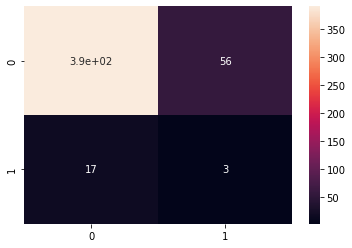

In [261]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred['Prediccion'])
sns.heatmap(cf_matrix, annot=True)
plt.show()

## Modelo 

__1. Crea el modelo que consideres apropiado para estimar el dinero que se moverá en Xepelin durante junio 2022. Explica porque seleccionaste este tipo de modelo, que supuestos consideraste y cuáles alternativas evaluaste.__

_Nuestro modelo va a hacer dos cosas:_

1. <p style='text-align: left;'>Estimar la probabilidad de que un pago sea exitoso para cada empresa $i$ con id de pago $j$, dado los features de la empresa $i$ y pago $j$.</p>

<center> $P(Status_{ij}=Paid| X_i,X_j)$ </center>

2. <p style='text-align: left;'>Estimar el monto esperado de pago Y condicionado los features de la empresa $i$ y features del pago $j$, y el valor esperado del estado del pago.</p>

<center> $E(Y_{ij}|X_i,X_j,Status_{ij})=E(Y_{ij}|X_i,X_j,Status_{ij})*E(Status_{ij}=Paid| X_i,X_j)$ <center><br>

_Esto lo hacemos por tres razones:_
    
1. <p style='text-align: left;'> Un modelo de regresión pura sobreestimaría la cantidad efectiva pagada porque el pago registrado en la base no toma en cuenta si el pago fue válido o no.</p>
2. <p style='text-align: left;'> Un modelo de clasificación puro podría no tomar en cuenta si la empresa efectuará un pago el siguiente periodo.</p>

____3. ¿Qué información adicional considerarías relevante para mejorar tu modelo?____
    
Información acerca de la empresa: Giro, numero de empleados, ingresos y egresos.
    
Información de la naturaleza del prestamo, para qué se utilizó.
    
____4. ¿Cuáles son las ventajas que tendría Xepelin si implementara el modelo que propones?____

Tendrían una manera para minimizar el monto de dinero patronicado por Xepelin que termina en pago fallido. 
 
____5. ¿Cuáles son los problemas que tendría Xepelin para implementar tu modelo?____

Habría que accesar datos en diferentes niveles, con diferentes niveles de privacidad. 